In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.ticker as mticker
from datetime import datetime
from scipy.interpolate import griddata

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings('ignore')

In [2]:
values = []
with open('/Users/marlis/Developer/SLI/Sea-Level-Indicators/ref_files/akiko_colorscale.txt', 'r') as f:
   lines = f.readlines()
   for line in lines:
      vals = line.split()
      row = [float(v)/256 for v in vals]
      row.append(1)
      values.append(row)
my_cmap = colors.ListedColormap(values, name='my_colormap_name')

In [25]:
def get_decimal_year(dt: datetime):
    
    year_start = datetime(dt.year, 1, 1)
    year_end = year_start.replace(year=dt.year+1)
    return dt.year + ((dt - year_start).total_seconds() /  # seconds so far
        float((year_end - year_start).total_seconds()))  # seconds in year

def interp(lats, lons, data):
    array = np.ma.masked_invalid(data)
    xx, yy = np.meshgrid(lons, lats)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    nn_data = griddata((x1, y1), newarr.ravel(), (xx, yy),  method='nearest')
    print(nn_data)
    # grid_x, grid_y = np.meshgrid(np.arange(0.125,360.125, 0.25), np.arange(-89.875,90.125,0.25))
    grid_x, grid_y = np.meshgrid(np.arange(-9.825,369.825, 0.25), np.arange(-89.875,90.125,0.25))


    # Interpolate onto finer grid and reshape
    interpolated_values = griddata((xx.flatten(), yy.flatten()), nn_data.ravel(), (grid_x, grid_y), method='cubic')
    interp_values_2d = np.reshape(interpolated_values, (len(grid_x), len(grid_y[0])))

    return interp_values_2d


def smoothing(lats, lons, data):

    interp_ssha_2d = interp(lats, lons, data)

    interp_ds = xr.Dataset(
        data_vars=dict(
            SSHA=(['latitude', 'longitude'], interp_ssha_2d),
        ),
        coords=dict(
            # latitude=(['latitude'], np.arange(-89.875,90.125,0.25)),
            # longitude=(['longitude'], np.arange(0.125, 360.125, 0.25))
            latitude=(['latitude'], np.arange(-89.875,90.125,0.25)),
            longitude=(['longitude'], np.arange(-9.825,369.825, 0.25))
        )
    )
    interp_ds.to_netcdf('post_interp_pre_smooth.nc')
    # Do boxcar averaging
    dsr = interp_ds.rolling({'longitude':38, 'latitude':16}, min_periods=600).mean()
    hr_mask_ds = xr.open_dataset('/Users/marlis/Developer/SLI/Sea-Level-Indicators/ref_files/HR_GRID_MASK_latlon.nc')
    hr_mask_ds.coords['longitude'] = hr_mask_ds.coords['longitude'] % 360
    hr_mask_ds = hr_mask_ds.sortby(hr_mask_ds.longitude)
    dsr = dsr.sel(longitude=slice(0,360))

    dsr.SSHA.values = np.where(hr_mask_ds.maskC.values == 0, np.nan, dsr.SSHA.values)

    dsr_subset = dsr.sel(latitude=slice(-80,80))
    dsr_subset.to_netcdf('smooth_interp_subset.nc')

    return dsr_subset

In [4]:
def plot_orth(lats, lons, data, date):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-150, 10))
    g = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), vmin=-180, vmax=180, cmap=my_cmap,shading='nearest')
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.75,zorder=12)
    gl.xlocator = mticker.FixedLocator([])
    gl.ylocator = mticker.FixedLocator([0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.set_facecolor('black')

    plt.annotate(date, (75, 615),
            xycoords='figure pixels',
            horizontalalignment='left',
            verticalalignment='top',color='white', weight='bold', fontsize=12)
    plt.annotate('Jason-3', (600, 615),horizontalalignment='right',
            verticalalignment='top', xycoords='figure pixels', color='white', weight='bold', fontsize=12)

    plt.show()

def plot_plate(lats, lons, data, date):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(-180))
    g=ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), vmin=-180, vmax=180, cmap=my_cmap)
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=.5, linestyle='--', zorder=15)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([40, 80, 120, 160, -160, -120, -80, -40])
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.xaxis.set_minor_formatter(LONGITUDE_FORMATTER)
    plt.title(f'{date}\nJASON-3')
    cb = plt.colorbar(g, orientation="horizontal", shrink=0.75, aspect=30)
    cb.set_label('MM')
#     plt.ylim([-65,65])
    plt.show()
    # plt.scatter()

In [17]:
test_path = '/Users/marlis/Developer/SLI/sli_output/gridded_cycles/ssha_global_half_deg_20120820.nc'
ds = xr.open_dataset(test_path)
ds.coords['longitude'] = (ds.coords['longitude']) % 360
ds = ds.sortby(ds.longitude)
lats = ds.latitude.values
lons = ds.longitude.values
data = ds.SSHA.values * 1000
counts = ds.counts.values
date = datetime.utcfromtimestamp(ds.time.values.tolist()/1e9)
print(date)
date_str = datetime.strftime(date, '%b %d %Y')

2012-08-20 00:00:00


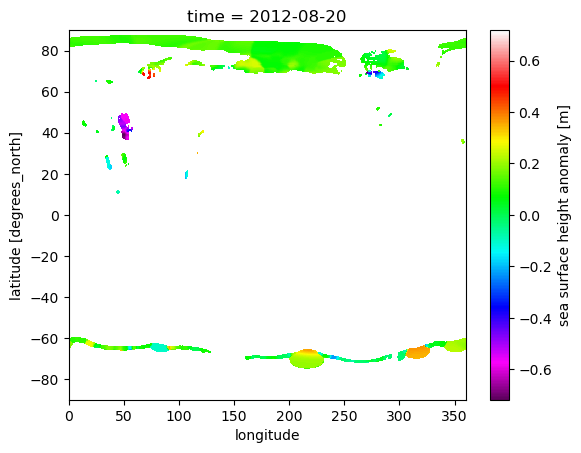

In [18]:
filt_ds = ds.where(ds.counts < 475, np.nan)
filt_ds.SSHA.plot(cmap=my_cmap)

In [19]:
# Get seasonal cycle for date
decimal_year = get_decimal_year(date)
yr_fraction = decimal_year - date.year
seas_ds = xr.open_dataset('../../ref_files/trnd_seas_simple_grid.nc')
seas_ds.coords['Longitude'] = (seas_ds.coords['Longitude']) % 360
seas_ds = seas_ds.sortby(seas_ds.Longitude)
cycle_ds = seas_ds.interp({'Month_grid': yr_fraction})
removed_cycle_data = data - (cycle_ds.Seasonal_SSH.values * 10)
trend = (decimal_year * seas_ds.SSH_Slope * 10) + (seas_ds.SSH_Offset * 10)
removed_cycle_trend_data = removed_cycle_data - trend
filt_ds.SSHA.values = removed_cycle_trend_data

In [20]:
front = filt_ds.sel(longitude=slice(0,10))
back = filt_ds.sel(longitude=slice(350,360))
front = front.assign_coords({'longitude': front.longitude.values + 360})
back = back.assign_coords({'longitude': back.longitude.values - 360})
padded_ds = xr.merge([back, filt_ds, front])
padded_ds

<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 760)
Coordinates:
  * longitude  (longitude) float64 -9.75 -9.25 -8.75 -8.25 ... 368.8 369.2 369.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time       datetime64[ns] 2012-08-20
Data variables:
    SSHA       (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    counts     (latitude, longitude) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    mask       (latitude, longitude) float32 nan nan nan nan ... 1.0 1.0 1.0 1.0

In [26]:
smooth_ds = smoothing(padded_ds.latitude.values, padded_ds.longitude.values, padded_ds.SSHA.values)

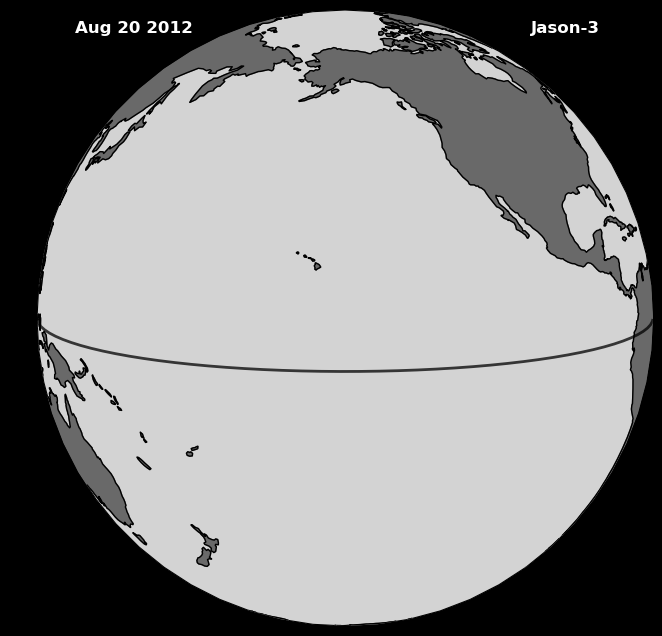

In [27]:
plot_orth(smooth_ds.latitude, smooth_ds.longitude, smooth_ds.SSHA, date_str)

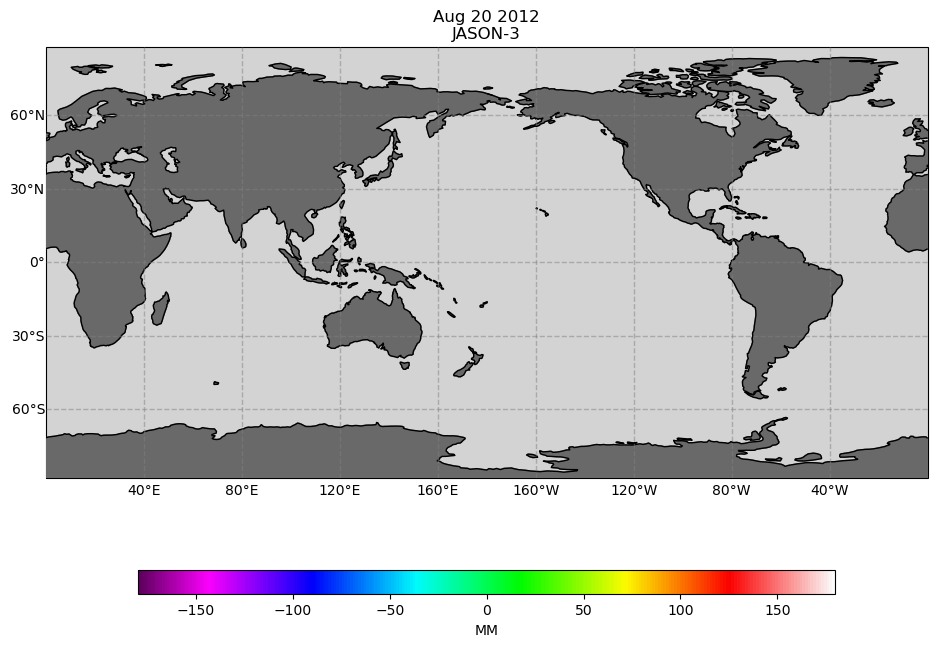

In [28]:
plot_plate(smooth_ds.latitude, smooth_ds.longitude, smooth_ds.SSHA, date_str)